## 예측

In [1]:
import numpy as np
import pandas as pd

# 시드 설정
np.random.seed(42)

# 데이터 생성
months = pd.date_range(start='2022-01-01', periods=24, freq='M')  # 24개월간의 데이터
account_categories = ['여비교통비', '접대비', '회의비', '복리후생비', '통신비', '사무용품비', '교육훈련비', '소모품비', '임차료', '출장비', '수수료']  # 계정과목 리스트

# 각 금액을 10의 배수로 생성하도록 조정
data = {
    'Month': np.repeat(months, len(account_categories)),
    'Account': account_categories * len(months),
    'Amount': np.random.randint(100, 100000, size=len(months) * len(account_categories)) * 10  # 10,000원에서 1,000,000원 사이의 랜덤 금액
}

# 데이터프레임 생성
df = pd.DataFrame(data)

# 상위 10개 레코드 출력
df.head(10)


/var/folders/pw/w8rt727n6j51gnhj0dxq0xlw0000gn/T/ipykernel_51708/2070222299.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  months = pd.date_range(start='2022-01-01', periods=24, freq='M')  # 24개월간의 데이터


,Month,Account,Amount
0,2022-01-31,여비교통비,158950
1,2022-01-31,접대비,9600
2,2022-01-31,회의비,769200
3,2022-01-31,복리후생비,549860
4,2022-01-31,통신비,63650
5,2022-01-31,사무용품비,824860
6,2022-01-31,교육훈련비,372940
7,2022-01-31,소모품비,875980
8,2022-01-31,임차료,442310
9,2022-01-31,출장비,603630


In [2]:
# 월별 계정과목별 총 금액 집계
df_pivot = df.pivot_table(index='Month', columns='Account', values='Amount', aggfunc='sum').fillna(0)
df_pivot.head()

Account,교육훈련비,복리후생비,사무용품비,소모품비,수수료,여비교통비,임차료,접대비,출장비,통신비,회의비
Month,,,,,,,,,,,
2022-01-31,372940,549860,824860,875980,161230,158950,442310,9600,603630,63650,769200
2022-02-28,650250,8690,630550,680690,538070,411900,54110,673210,832040,598350,649200
2022-03-31,185310,931160,845780,28470,847540,854050,592500,287930,658250,257580,720320
2022-04-30,691920,669030,114940,39900,801380,358730,417060,675350,963760,316510,569860
2022-05-31,239970,740690,766520,682480,172590,874130,235830,107270,486550,431010,88920


In [3]:
# 회귀 분석
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# 예측 준비 (각 계정과목에 대해 개별적으로 예측)
predictions = {}
for account in account_categories:
    X = np.array(range(len(df_pivot))).reshape(-1, 1)  # 달 수를 Feature로 사용
    y = df_pivot[account].values
    
    # 훈련 및 테스트 데이터 분리
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    # 모델 훈련
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # 다음 달 예측
    next_month = np.array([[len(df_pivot)]])  # 다음 달을 예측
    predictions[account] = model.predict(next_month)[0]

# 예측 결과 출력
print("다음 달 예측된 비용 (계정과목별):")
for account, amount in predictions.items():
    print(f"{account}: {amount:.2f} 원")


다음 달 예측된 비용 (계정과목별):
여비교통비: 559596.58 원
접대비: 519862.11 원
회의비: 535943.68 원
복리후생비: 645996.05 원
통신비: 455672.11 원
사무용품비: 775510.00 원
교육훈련비: 657977.11 원
소모품비: 180202.63 원
임차료: 719509.21 원
출장비: 250760.53 원
수수료: 642362.63 원


In [7]:
########## 시각화 ###########
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# 스타일 설정
plt.style.use('seaborn-dark')

# 시드 설정
np.random.seed(42)

# 데이터 생성
months = pd.date_range(start='2022-01-01', periods=24, freq='M')
account_categories = ['여비교통비', '접대비', '회의비', '복리후생비', '통신비', '사무용품비', '교육훈련비', '소모품비', '임차료', '출장비', '수수료']

# 각 금액을 10의 배수로 생성
data = {
    'Month': np.repeat(months, len(account_categories)),
    'Account': account_categories * len(months),
    'Amount': np.random.randint(1000, 100000, size=len(months) * len(account_categories)) * 10
}

# 데이터프레임 생성
df = pd.DataFrame(data)

# 피벗 테이블 생성: 각 계정과목별 월별 합계
df_pivot = df.pivot_table(index='Month', columns='Account', values='Amount', aggfunc='sum').fillna(0)

# 회귀 분석 및 예측
predictions = {}
for account in account_categories:
    X = np.array(range(len(df_pivot))).reshape(-1, 1)
    y = df_pivot[account].values
    
    # 훈련 및 테스트 데이터 분리
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    # 모델 훈련
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # 다음 달 예측
    next_month = np.array([[len(df_pivot)]])
    predictions[account] = model.predict(next_month)[0]

# 계정과목별로 개별 그래프 그리기
for account in account_categories:
    plt.figure(figsize=(10, 6))
    
    # 실제 데이터 그리기 (선 그래프)
    plt.plot(df_pivot.index, df_pivot[account], label=f"{account} (실제값)", color='dodgerblue', linewidth=2)
    
    # 예측된 다음 달 값 그리기 (점)
    next_month_date = df_pivot.index[-1] + pd.DateOffset(months=1)
    plt.scatter(next_month_date, predictions[account], color='red', marker='o', s=120, zorder=5, label=f"{account} (예측값)")

    # 그래프 설정
    plt.title(f'{account} 월별 사용 추이 및 예측', fontsize=16, fontweight='bold', pad=15)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Amount (원)', fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(loc='upper left', fontsize=10)
    plt.tight_layout(pad=2)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # 그래프 보여주기
    plt.show()




OSError: 'seaborn-dark' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

/Users/kimsomin/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/kimsomin/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 50977 (\N{HANGUL SYLLABLE YUG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/kimsomin/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 54984 (\N{HANGUL SYLLABLE HUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/kimsomin/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 47144 (\N{HANGUL SYLLABLE RYEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/kimsomin/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from current font.
 

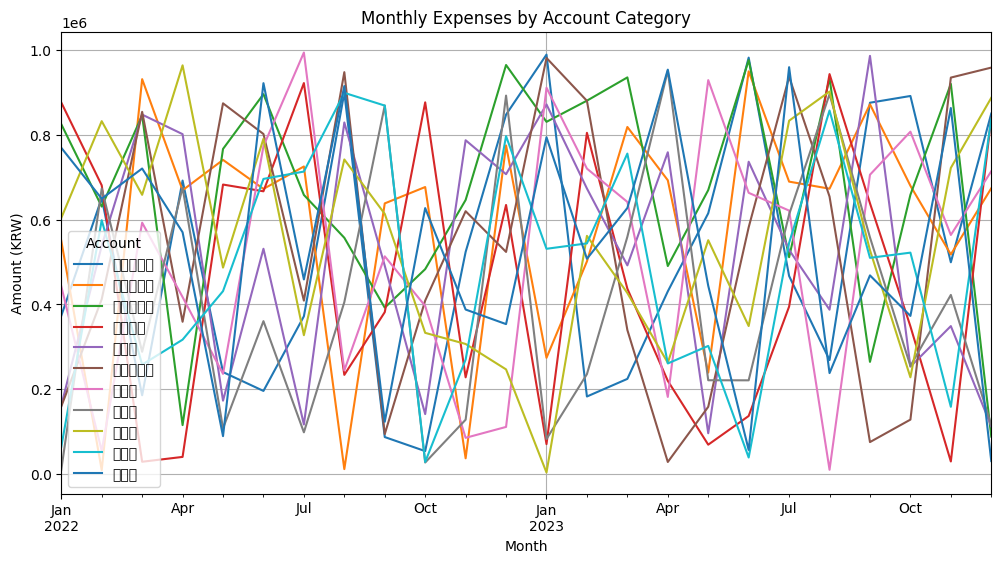

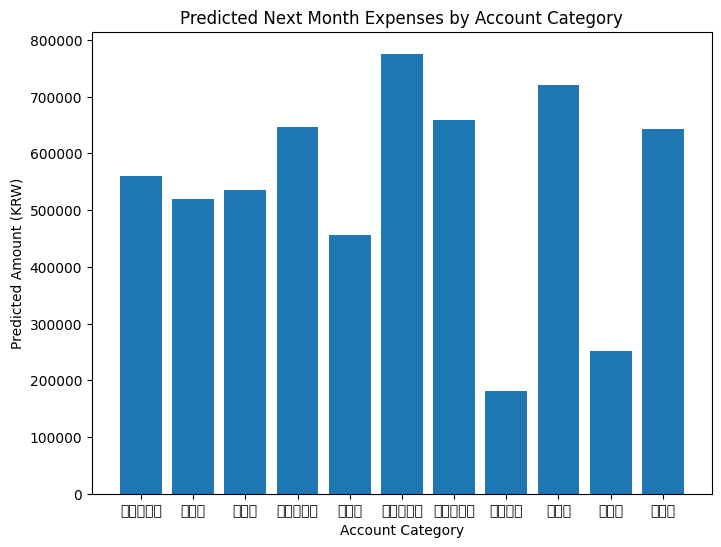

In [8]:
# 기존 데이터 시각화
df_pivot.plot(figsize=(12, 6))
plt.title('Monthly Expenses by Account Category')
plt.xlabel('Month')
plt.ylabel('Amount (KRW)')
plt.legend(title='Account')
plt.grid(True)
plt.show()

# 예측 결과 시각화
plt.figure(figsize=(8, 6))
plt.bar(predictions.keys(), predictions.values())
plt.title('Predicted Next Month Expenses by Account Category')
plt.xlabel('Account Category')
plt.ylabel('Predicted Amount (KRW)')
plt.show()